[View in Colaboratory](https://colab.research.google.com/github/NTT123/SGLD_AEVI/blob/master/Variational_Inference.ipynb)



# Differential Privacy for Bayesian Inference

*Abstract*. 

We propose a novel method to protect privacy for Bayesian inference.  We first transform the log-likelihood function into a bounded function using a sanitizer function. Then, we use mean field variational inference to approximate the posterior distribution. Next, we use the exponential mechanism with Kullback–Leibler divergence as the utility function to define a probability distribution of all mean-field approximations. 
Finally, we use stochastic gradient Langevin dynamics to draw a random mean field approximation from the probability distribution defined by the exponential mechanism with Kullback–Leibler divergence. The random mean field approximation guarantees differential privacy for individuals in the dataset.



## Introduction



The objective of Bayesian inference (previously known as inverse probability) is to compute the posterior distribution of latent parameters given the observed data. Let $\theta$ be the parameter vector of the model and $x$ be the observed data. By Bayes' theorem, we have:
$$
P(\theta \mid x) = \frac{P(x \mid \theta) \times P(\theta)}{P(x)}
$$

Here $P(\theta \mid x)$ is the posterior distribution of $\theta$, $P(\theta)$ is the prior distribution, $P(x \mid \theta)$ is the likelihood function and $P(x)$ is  the evidence. $P(x)$ can be computed as follows:
$$
P(x) =  \int_\theta P(x \mid \theta) P(\theta) d\theta
$$

However,  this integral is untractable in general. There are two general approach to tackle this problem: (1) monte carlo markov chains (MCMC) algorithm and (2) variational inference (VI). MCMC algorithm constructs a markov chain whose statationary distribution is $P(\theta \mid x)$. Meanwhile, VI approximates $P(\theta \mid x)$ by a parametrized  and tractable distribution $Q(\theta \mid z)$ such that $Q(\theta \mid z)$ is as close as possible to $P(\theta \mid x)$.

Here, we aim to protect the privacy of individuals in the dataset, which is used by Bayesian inference as of the observed data $x$. Especially, we aim to guarantee differential privacy for Bayesian inference.  Differential privacy is a robust and mathematical definition of privacy protection which guarantees that each individual's data does not much influent on the soon-be-published information which is extracted from the dataset of these individuals. Let $z$ be the information which is extracted from the dataset $x$.  Differential privacy constructs a probability distribution  $P(z \mid x)$ which is the distribution of $z$ given $x$. The bits of information will be published is a random sample of $P(z \mid x)$:
$$
z_{priv} \sim P(z \mid x)
$$

Differential privacy guarantees that for any two neighbouring dataset $x$ and $x^\prime$ which are different at only one data record, $P(z\mid x)$ and $P(z \mid x^\prime)$ are close to each other. For any neighbouring dataset $x$ and $x^\prime$, and for any $z$:
$$
P(z \mid x) \leq \exp(\epsilon) \cdot P(z \mid x^\prime)
$$

Here, $\epsilon$ is called the privacy budget. Low $\epsilon$ guarantees strong privacy, otherwise high $\epsilon$ guarantees weak privacy.

In this work, $z$, which is the extracted information from dataset $x$, is actually the parameter vector of the mean field variational distribution $Q(\theta \mid z)$. In other words, we aim to guarantee that publishing parameters of the approximated posterior distribution will not compromise the privacy of individuals data record in $x$.

There are previous works related to this problem. Wang et al. [1] are the first to prove that sampling a single random sample from the posterior distribution guarantees differential privacy under some conditions. The authors use stochastic gradient Monte-Carlo to sample the posterior distribution. Park et al. [2] proposed that for variational inference with conjugate exponential (CE) family, it is enough for guaranteeing differential privacy by perturbing the expected sufficient statistics of the complete-data likelihood. J{\"a}lk{\"o} et al. [3]  proposed to guarantee differential privacy for variational inference with non-conjugate models by a Gaussian mechanism which adds gaussian noise to the gradient vector at each step of the optimization procedure.   



[1] Privacy for Free: Posterior Sampling and Stochastic Gradient Monte Carlo 

@inproceedings{wang2015privacy,
  title={Privacy for free: Posterior sampling and stochastic gradient monte carlo},
  author={Wang, Yu-Xiang and Fienberg, Stephen and Smola, Alex},
  booktitle={International Conference on Machine Learning},
  pages={2493--2502},
  year={2015}
}

[2] Variational Bayes In Private Settings (VIPS)
@article{park2016variational,
  title={Variational Bayes in private settings (VIPS)},
  author={Park, Mijung and Foulds, James and Chaudhuri, Kamalika and Welling, Max},
  journal={arXiv preprint arXiv:1611.00340},
  year={2016}
}

[3] Differentially Private Variational Inference for Non-conjugate Models
@inproceedings{jalko2017differentially,
  title={Differentially Private Variational Inference for Non-conjugate Models},
  author={J{\"a}lk{\"o}, Joonas and Dikmen, Onur and Honkela, Antti and others},
  booktitle={Uncertainty in Artificial Intelligence 2017 Proceedings of the 33rd Conference, UAI 2017},
  year={2017},
  organization={The Association for Uncertainty in Artificial Intelligence}
}

## Method

The main idea of our method is to use exponential mechanism to define a probability distribution of vector $z$ with the utility function $U(z; x)$ based on the Kullback–Leibler divergence score. The probability density function of $z$ is defined as follows:
$$
f_Z(z) \propto \exp\left( \frac{U(z; x)}{2\Delta_U} \cdot \epsilon\right) 
$$
where $\Delta_U$ is the sensitivity of the utility function $U$.  For any $z$ and any pair of neighbouring datasets $x$ and $x^\prime$,
$$
\Delta_U = \max_{z, x, x^\prime} \left| U(z; x) - U(z; x^\prime) \right|
$$
It is proven that a random sample from above distribution guarantees $\epsilon$-differential privacy. 





Here, we define the utility function equal to the variational lowerbound as follows: 
$$
\begin{align}
U(z; x) &= \log\left( P(x) \right) - D_{KL} \left( Q(\theta \mid z) ~\|~ P(\theta \mid x) \right) \\
&= \mathrm{E}_Q \left[   \log\left(P(x \mid \theta)\right) + \log\left( P(\theta)\right)  - \log\left(Q(\theta \mid z)\right) \right]
\end{align}
$$



Then, the sensitivity of $U$ is
$$
\Delta_U = \max_{z, x, x^\prime}  \left| \mathrm{E}_Q \left[  \log\left(P(x \mid \theta\right) - \log\left(P(x^\prime \mid \theta) \right)\right] \right|
$$

Let $\ell(\theta; x_i)$ is the log-likelihood of function of $i^{th}$ data record, then $$ P(x \mid \theta) = \sum_{i=1}^n \ell(\theta; x_i)$$ where $n$ is the size of dataset $x$. Now, assuming that two neightbouring dataset $x$ and $x^\prime$ are differ at only $x_n$ and $x^\prime_n$,
$$
\Delta_U = \max_{z, x, x^\prime} \left | \mathrm{E}_Q \left[ \ell(\theta; x_n) - \ell(\theta; x_n^\prime)\right] \right|
$$

So, the objective here is to bound $\Delta_U$ by a finite number. We here achive that by approximate $\ell(\theta; x_i)$ by a finite log-likelihood function  $\gamma(\theta; x_i)$ as follows:
$$
\gamma(\theta; x_i) = \tau \cdot \textrm{tanh}\left( \frac{\ell(\theta; x_i)}{\tau} \right)
$$ where $[-\tau; \tau]$ is the range of $\gamma(\cdot)$. The below figure shows the effect of the approximation to an identity function with $\tau = 2.0$:

In [32]:
#@title
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
import tensorflow as tf

#@title
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 4,3
rcParams['font.size'] = 14
plt.style.use('ggplot')

plt.rcParams['font.serif'] = 'dejavuserif'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 16

torch-0.4.0-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


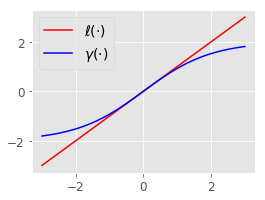

In [33]:
#@title Figure 1. Bounded log-likelihood function

from pylab import rcParams
import matplotlib.pyplot as plt

import torch

rcParams['figure.figsize'] = 4,3
x = torch.linspace(-3, 3, 100)
y1 = x.clone()
tau = 2.0
y2 = tau * torch.tanh(y1 / tau)
plt.plot(x.numpy(), y1.numpy(), "r-")
plt.plot(x.numpy(), y2.numpy(), "b-")
plt.legend(['$\ell(\cdot)$', '$\gamma(\cdot)$' ])
plt.show()

The idea here is to keep the shape of the log-likelihood function $\ell(\cdot)$ at *important values* near $0$ and deform the function at other values to keep it finite.

It is then guaranteed that by using $\gamma$ instead of $\ell$ as the log-likelihood function,
$$
\Delta_U \leq 2\tau
$$

Next, we now aim to draw a random sample from $f_Z(z)$, we use stochastic gradient langevin dynamics (SGLD) to achieve this goal. The basic idea of SGLD is that a particle will follow the noisy gradient of its current location, which is adding a Gaussian noise to the gradient. After a long time, the probability distribution of the particle converges to the distribution we want. In our case, we have:
$$
z_{t+1} = z_t + \frac{\epsilon}{2\Delta_U}\cdot \nabla U(z; x) \cdot \delta_t + r \cdot \sqrt{2 \delta_t}
$$
where $r \sim \mathcal N(0, 1)$ and $\delta_t$ is the step size at time $t$.

We here assume that we can use the reparameterization trick for the probability $Q(\theta \mid z )$. In other words, we assume that we can represent $Q$ as follows:
$$
\begin{align}
r &\sim  P(r) \\
\theta  &= g(z, r)
\end{align}
$$

Therefore, $U(z; x)$ can be approximate by:
$$
U(z; x) \approx  \frac 1 L \sum_{i=1}^L  \left(\log\left(P(x \mid \theta_i)\right) + \log\left( P(\theta_i)\right)  - \log\left(Q(\theta_i \mid z)\right)  \right)
$$
where $\theta_i = g(z, r_i)$ and $r_i \sim P(r)$. This approximate allows us to estimate the gradient of $U(z; x)$.

## Experiments

### Data 


$$
\begin{align}
Y &= a X_1 + b X_2 + intercept + r \\
r &\sim \mathcal N(0, \sigma^2)
\end{align}
$$

We generate a dataset with 
$$
\begin{align}
a  &= +2.0 \\
b &= -3.5 \\
intercept &= -5.0 \\
\sigma &= +0.1
\end{align}
$$


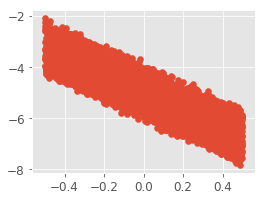

In [34]:
#@title Generate Data
import torch
N = 4000

isCuda = False
if torch.cuda.device_count() > 0:
    isCuda = True

    
isCuda = False

a = 2.0
b = -3.5
intercept = -5.0
noise = 0.1

### 

#@title
def generateData():
    X = torch.rand(N, 2) - 0.5
    theta = torch.zeros(2, 1)
    theta[0, 0] = a
    theta[1, 0] = b
    Y = torch.mm(X, theta) + intercept + noise * torch.randn(N, 1)
    data = torch.Tensor( N, 3 )
    data[:, 0:2] = X
    data[:, 2] = Y[:,0]
    return data, X, Y

#@title
data, X, Y = generateData()
if isCuda:
    data = data.cuda()
    X = X.cuda()
    Y = Y.cuda()
    
import seaborn as sns
_ = plt.scatter(X[:, 1], Y[:,0])

In [35]:
#@title Posterior function

def log_prior(theta):
    coeff = theta[0:3]
    sigma = theta[3]
    hc = HalfCauchy(0.0, 10.0)

    sigma1 = 10.0
    
    return torch.sum(  -torch.pow(coeff, 2) * 0.5 / (sigma1**2) \
                     -  math.log(sigma1) )  + hc.log_pdf_param(sigma)

def log_likelihood(theta, data):
    X = data[:, 0:2]
    Y = data[:, 2:3]
    slope = theta[0:2]
    intercept = theta[2]
    sigma = torch.exp(theta[3])
    return torch.sum(- torch.pow(Y - (torch.mm(X, slope) + intercept), 2) * 0.5\
                          / torch.pow(sigma, 2) - theta[3]  )

def log_posterior(theta, data):
    return log_likelihood(theta, data) + log_prior(theta)


import math
class HalfCauchy:
    def __init__(self, median, scale):
        self.x0 = median
        self.gamma = scale
    def log_pdf(self, x):
        inv =   math.log(math.pi) + math.log(self.gamma) + \
                    torch.log( 1.0 + torch.pow(x - self.x0, 2) / self.gamma)
        
        return math.log(2.0) - inv
    
        
    def get(self, param):    
        return torch.exp(param)
    
    def pdf(self, param):
        return torch.exp(  self.log_pdf(self.get(param)) )
    
    def log_pdf_param(self, param):
        x = torch.exp(param)
        return self.log_pdf(x) + param
        
    def pdf_param(self, param):
        #self.param.zero_()
        #self.param[0] = param
        x = torch.exp(param)
        return self.pdf(x) * torch.exp(param)     
    
    
theta = torch.zeros(4, 1, requires_grad=True)
if isCuda:
    theta = theta.data.cuda()
theta.requires_grad= True

In [36]:
#@title
def computeK(p):
    return torch.sum(torch.pow(p,2) / 2.0).data

def computeU(theta, data):
    return -log_posterior(theta, data)

def computeH(theta, p, data):
    return computeK(p) + computeU(theta, data)


def gradientOfU(theta, data):
    theta.requires_grad= True
    if torch.is_tensor(theta.grad):
        theta.grad.zero_()
    out = computeU(theta, data)
    out.backward()
    theta.requires_grad= False
    return theta.grad.data

def gradientOfK(p):
    return p

data.requires_grad = False
!pip install tqdm
import tqdm

distributed 1.22.0 requires msgpack, which is not installed.


### Maximum-a-posteriori (MAP) estimation

In [37]:
#@title
optimizer = torch.optim.SGD([ theta ], lr=1e-2)
for t in tqdm.tqdm(range(100000)):
    loss = -log_posterior(theta, data) / N
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(loss.item())


  5%|▌         | 5017/100000 [00:04<01:28, 1075.76it/s]


 14%|█▍        | 14281/100000 [00:12<01:08, 1254.90it/s]

100%|██████████| 100000/100000 [01:16<00:00, 1311.62it/s]

-1.8227145671844482


In [38]:
#@title
print( "a = %f\nb=%f\nintercept=%f\nsigma=%f" % (theta[0,0].item(),
                                                  theta[1,0].item(),
                                                  theta[2,0].item(),
                                                  math.exp(theta[3,0].item()) ))

a = 1.993653
b=-3.496528
intercept=-5.000208
sigma=0.097722


In [39]:
#@title
!pip install pystan

distributed 1.22.0 requires msgpack, which is not installed.


In [40]:
#@title
import pystan

linreg_code = """
data {
    int<lower=0> N;
    matrix[N, 2] x; 
    real y[N]; 
}
parameters {
    real intercept;
    vector[2] theta;
    real<lower=0> sigma;
}


model {
    vector[N] yhat;
    theta ~ normal(0.0, 10.0);
    intercept ~ normal(0.0, 10.0);
    sigma ~ cauchy(0.0, 1.0);
    
    yhat = x * theta + intercept;    
    
    y ~ normal(yhat, sigma);
}
"""

## sm = pystan.StanModel(model_code=linreg_code)
#@title
X = data[:, 0:2]
Y = data[:, 2:3]

dat = {'N':N, 
       'x': X.cpu().numpy().reshape( (N, 2)),
       'y': Y.cpu().numpy().reshape( (N) )  }

fit = sm.sampling(data=dat, iter=10000, chains=1)

/Users/xcode/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


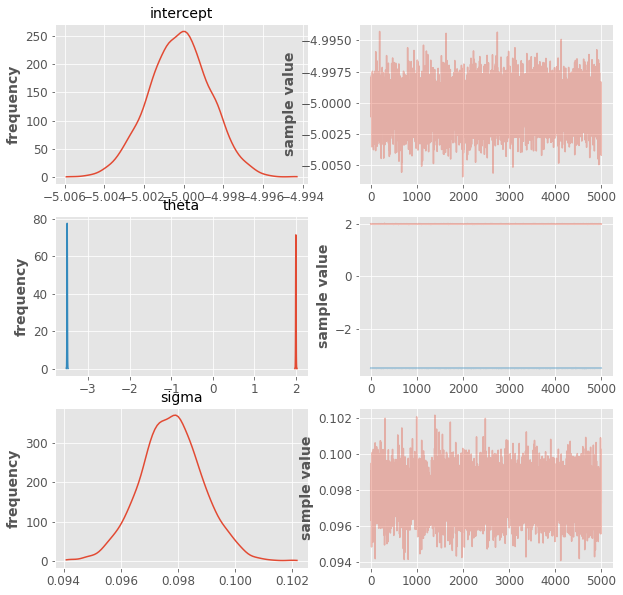

In [41]:
#@title
rcParams['figure.figsize'] = 10,10
fit.plot()
rcParams['figure.figsize'] = 4,3
samples = fit.extract()

mytheta = torch.empty(len(samples['theta']), 4)
mytheta[:, 0:2] = torch.from_numpy(samples['theta'])
mytheta[:, 2]   = torch.from_numpy(samples['intercept'])
mytheta[:, 3]   = torch.from_numpy(samples['sigma'])

### Variational Inference


Instead of drawing random samples from the posterior distribution $ P(z \mid x)$, we could approximate the posterior distribution by a simpler distribution, e.g. Normal distributions. We here approximate the posterior distribution by a family of distributions whose coordinates  are independent Gaussian distributions $$ Q(z_i) = \mathcal N(\bar z_i, \sigma_i^2)$$
So $$Q(z) = \prod_{i=1}^d Q(z_i)$$


The objective is to choose $\hat z_i, \sigma_i$ such that the distance between $Q(z)$ and $P(z \mid x)$ is minimized. Here, we use the Kullback–Leibler divergence (KLD) to measure the distance.
$$
\begin{align}
D_{KL}  \left(Q(z) \| P(z | x) \right)  &= E_{Q}  \left( \log(Q(z)) - \log(P(z \mid x))  \right)\\
&=  E_{Q}  \left( \log(Q(z)) - \log(P(x \mid z)) - \log(P(z) + \log(P(x))  \right) \\
&\geq E_Q \left( \log(Q(z)) - \log(P(x \mid z)) - \log(P(z)  \right)
\end{align}
$$


We here use reparametriczation trick to represent the distribution $Q(z_i)$ as follows:
$$
\begin{align}
Q(z_i) &= r_i \cdot \sigma_i + \bar z_i \\
r_i &\sim \mathcal N(0, 1)
\end{align}
$$

By doing that, we seperate the stochastis noise $r_i$ from parameters $r_i$ and $\bar z_i$. This allows us to compute the gradient of KLD with respect to these parameters.

We first draw multiple random samples of $r_i$ and use these samples to estimate the expectation of the gradient.


In [42]:
#@title

import torch 
def log_pdf_VI(theta, tau, sigma):
     #return torch.sum(- torch.pow((theta - tau) / sigma, 2) * 0.5 - torch.log(sigma))
     return torch.sum(- torch.log(sigma))

def generate_noise(n):
    return torch.randn(n, 4)


noise = generate_noise(10)
tau = torch.zeros(4, 1, requires_grad=True)
logsigma = torch.zeros(4, 1, requires_grad=True)
##noise * sigma.expand_as(noise) + tau.expand_as(noise)

if isCuda:
    tau = tau.cuda().data
    logsigma = logsigma.cuda().data
    tau.requires_grad=True
    logsigma.requires_grad=True

In [43]:
#@title
X = data[:, 0:2]
Y = data[:, 2:3]

#Auto-Encoding Variational Inference
def AEVI():
    ###theta = torch.zeros(4, 1, requires_grad=False)
    global tau, logsigma
    #tau = torch.randn(4, 1, requires_grad=True)
    #sigma = torch.ones(4, 1, requires_grad=True)
    optimizer = torch.optim.Adam([ tau, logsigma ], lr=1e-3)
    
    n = 1
    NN = 100000
    for it in tqdm.tqdm(range(NN)):
        if it == NN * 8 // 10:
            optimizer = torch.optim.Adam([ tau, logsigma ], lr=1e-4)
        loss = torch.zeros(1)
        if isCuda:
            loss = loss.cuda()
        mysigma = torch.exp(logsigma)
        ###sigma.data = torch.max(sigma, 1e-8*torch.ones_like(sigma))
        ##if isCuda:
        ##    sigma = sigma.cuda()
            
        for i in range(n):
            noise = torch.randn(4,1).data
            if isCuda:
                noise = noise.cuda()
            theta = noise * mysigma + tau
            loss = loss + 1.0 / n *  ( log_pdf_VI(theta, tau, mysigma) - log_posterior(theta, data))
        loss = loss / N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if it % 1000 == 0:
        #    print(loss.item())
    print(N*loss.item())
    return tau, logsigma

In [44]:
tau, logsigma = AEVI()

100%|██████████| 100000/100000 [01:29<00:00, 1113.57it/s]

-7269.19412612915


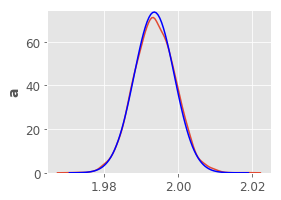

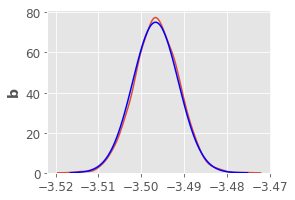

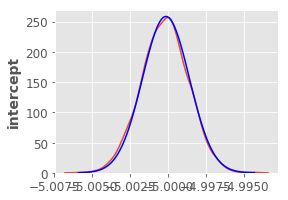

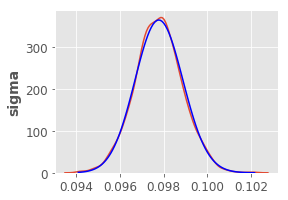

In [45]:
#@title
import seaborn as sns
name = ["a", "b", "intercept", "sigma"]


sigma = torch.exp(logsigma.data)
for id in range(4):
    ##myt = [ s[id,0] for s in Xs[0:]]



    ### myt = [ s[id,0] for s in Xs[0:]]




    xx = torch.linspace(float(min(mytheta[:, id].numpy())), float(max(mytheta[:, id].numpy())), 100)
    if id == 3:
        xx = torch.linspace(math.log(float(min(mytheta[:, id].numpy()))), math.log(float(max(mytheta[:, id].numpy()))), 100)
        
    yy =  torch.exp( - 0.5 * torch.pow ( (xx - tau.cpu()[id,0])\
           / sigma.cpu()[id,0], 2)) / math.sqrt( 2. * math.pi ) \
    / sigma.cpu()[id,0]

    
    if id == 3:
        ###myt = [math.exp(t) for t in myt]
        xx = torch.exp(xx)
        yy = yy / xx
        
    _ = sns.distplot(mytheta[:, id].numpy(), hist=False)

   # _ = plt.legend(['Variational Inference'])        
        
    _ = plt.plot(xx.cpu().data.numpy(), yy.cpu().data.numpy(), "b-")

    #_ = plt.legend(['Variational Inference', 'Hamiltonian Monte Carlo'])
    plt.ylabel(name[id])
    plt.show()


In [46]:
#@title
logsigma_bak = logsigma.clone()
tau_bak = tau.clone()
logsigma = logsigma.data
tau = tau.data

In [72]:
#@title
### noise = generate_noise(10)
tau = tau_bak.data # torch.zeros(4, 1, requires_grad=True)
#sigma = sigma_bak.data # torch.ones(4, 1, requires_grad=True)
logsigma =  logsigma_bak.data # torch.log(sigma_bak.data)
##noise * sigma.expand_as(noise) + tau.expand_as(noise)

if isCuda:
    tau = tau.cuda().data
    logsigma = logsigma.cuda().data
    tau.requires_grad=True
    logsigma.requires_grad=True

In [76]:
#@title
#Auto-Encoding Variational Inference - Stochastic Gradient Langevin Dynamics
def AEVI_SGLD():
    global tau, logsigma
    #tau = torch.zeros(4, 1, requires_grad=True)
    #sigma = torch.ones(4, 1, requires_grad=True)

    if isCuda:
        tau = tau.cuda().data
        logsigma = logsigma.cuda().data
        tau.requires_grad=True
        logsigma.requires_grad=True
    
    et = 1e-6
    
    samples = []
    
    n = 1
    var_tau = torch.zeros_like(tau)
    var_sigma = torch.zeros_like(logsigma)
    s_tau = torch.ones_like(tau)
    s_sigma = et*torch.ones_like(logsigma)
    s2_tau = et*math.sqrt(2.0*et)*torch.ones_like(tau)
    s2_sigma = math.sqrt(2.0*et)*torch.ones_like(logsigma)
    NN = 300000
    lim = NN // 4
    for it in tqdm.tqdm(range(NN)):
        logsigma.requires_grad = True
        tau.requires_grad = True
        loss = torch.zeros(1)
        if isCuda:
            loss = loss.cuda()
            
        for i in range(n):
            noise = torch.randn(4,1, requires_grad=False)
            if isCuda:
                noise = noise.cuda()
                
            mysigma = torch.exp(logsigma)
            qtheta = noise * mysigma + tau
            loss = loss + 1.0 / n *  ( log_pdf_VI(qtheta, tau, mysigma) - log_posterior(qtheta, data))
        loss = loss 
        
        
        loss.backward()
        
        #if it % 100 == 0:
        #    print(logsigma.grad.data, tau.grad.data)

        if it < lim:
            var_tau = var_tau +  torch.pow(tau.grad.data, 2)
            var_sigma = var_sigma + torch.pow(logsigma.grad.data, 2)
            tau_noise = torch.randn_like(tau) * math.sqrt(2*et) 
            sigma_noise = torch.randn_like(logsigma) * math.sqrt(2*et) 

            tau = tau.data - et * tau.grad.data + tau_noise
            logsigma = logsigma.data - et * logsigma.grad.data + sigma_noise 
            
        elif it == lim:
            et = 4e-3
            s_tau = et / torch.sqrt(var_tau/lim)
            s_sigma = et / torch.sqrt(var_sigma/lim)
            s2_tau = torch.sqrt(2*s_tau.data)
            s2_sigma = torch.sqrt(2*s_sigma.data)
        else:
            tau_noise = torch.randn_like(tau) * s2_tau
            sigma_noise = torch.randn_like(logsigma) * s2_sigma

            tau = tau.data - s_tau * tau.grad.data + tau_noise
            logsigma = logsigma.data - s_sigma * logsigma.grad.data + sigma_noise 

            samples.append(  ( tau.data.numpy(), logsigma.data.numpy() ) )
        #if it % 1000 == 0:
        #    print(loss.item())
    return samples

In [77]:
samples = AEVI_SGLD()

100%|██████████| 300000/300000 [04:04<00:00, 1228.04it/s]


/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6

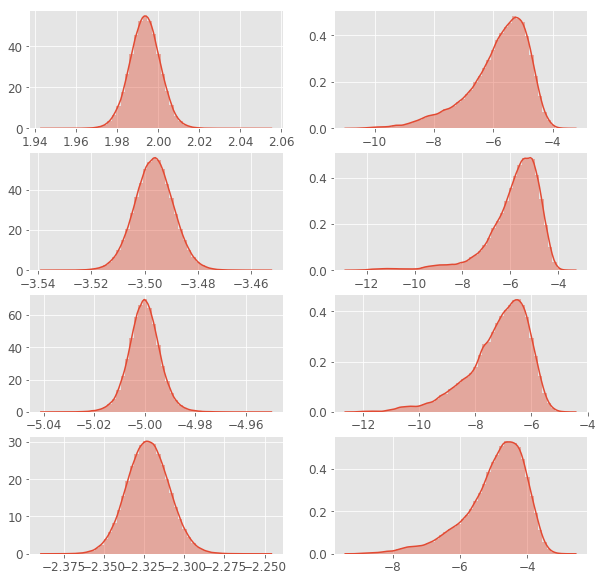

In [78]:
#@title
rcParams['figure.figsize'] = 10,10

for id in range(4):
    for yy in range(2):
        plt.subplot(4,2,id*2 + yy+1)
        ss = [ sample[yy][id] for sample in samples if math.isfinite(sample[yy][id])]
        sns.distplot(ss)

In [79]:
import tensorflow as tf
import math
import numpy as np
import tqdm
sess = tf.Session()

taubound = 4.0

def log_prior(co, logsigma):
    sigma = tf.exp(logsigma)
    gamma = 1.0
    x0 = 0.0

    log_cauchy_sigma = math.log(math.pi) + math.log(gamma) + tf.log(  1.0 + tf.pow( sigma - x0, 2)/gamma)

    log_cauchy_logsigma = math.log(2.0) - log_cauchy_sigma + logsigma

    log_prior =   -tf.reduce_sum( tf.pow(co / 10.0, 2)  * 0.5  ) +  log_cauchy_logsigma
    return log_prior

def sanitizer(loglikelihood):
    return taubound * tf.tanh( loglikelihood / taubound)

def log_likelihood(coeff, intercept, logsigma, X, Y):
    tau = 2.0
    sigma = tf.exp(logsigma)
    Yhat =  tf.matmul(X, coeff) + intercept
    llh = -tf.pow((Y-Yhat)/sigma , 2) * 0.5 - logsigma
    return tf.reduce_sum(  sanitizer ( llh ) )

def log_pos(X, Y, theta):
    co = theta[0:3,:]
    coeff = theta[0:2,:]
    intercept = theta[2,0]
    logsigma = theta[3,0]

    return log_prior(co, logsigma) + log_likelihood(coeff, intercept, logsigma, X, Y)

In [80]:
tf.reset_default_graph()

with tf.device('/cpu:0'):
    D = tf.constant(data.numpy())
    X = D[:, 0:2]
    Y = D[:, 2:3]

    theta = tf.Variable(tf.zeros([4, 1]))

    log_posterior = log_pos(X, Y, theta)
    
    loss = -log_posterior / N

    ## grad_theta = tf.gradients(loss, theta)

    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(loss, var_list=[theta])

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for i in tqdm.tqdm(range(200000)):
    sess.run(train)

tttheta = sess.run(theta)
print(tttheta)

100%|██████████| 200000/200000 [01:15<00:00, 2644.57it/s]

[[ 1.9943571]
 [-3.496611 ]
 [-5.000044 ]
 [-2.275206 ]]


In [122]:
#@title
tf.reset_default_graph()

with tf.device('/cpu:0'):
    D = tf.constant(data.numpy())
    X = D[:, 0:2]
    Y = D[:, 2:3]
    
    vi_mean  = tf.Variable( tf.zeros([4,1]) )
    vi_logsigma = tf.Variable( tf.zeros([4,1]))
    vi_sigma = tf.exp(vi_logsigma)

    noi = tf.random_normal( [4, 1])
    sample = noi * vi_sigma + vi_mean
    log_posterior = log_pos(X, Y, sample)

    vi_loss = -(log_posterior + 10*tf.reduce_sum(vi_logsigma)) / N


    optimizer = tf.train.AdamOptimizer(1e-3)
    train = optimizer.minimize(vi_loss, var_list=[vi_mean, vi_logsigma])
    
    optimizer1 = tf.train.AdamOptimizer(1e-4)
    train1 = optimizer1.minimize(vi_loss, var_list=[vi_mean, vi_logsigma])

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
NN = 100000
for i in tqdm.tqdm(range(NN)):
    if i == (NN * 8) // 10:
        train = train1
    sess.run(train)

mm, ms =  sess.run( (vi_mean, vi_logsigma) )
print(mm)
print(ms)


100%|██████████| 100000/100000 [00:44<00:00, 2249.02it/s]

[[ 1.9936111]
 [-3.4969277]
 [-5.0000567]
 [-2.270344 ]]
[[-3.9523826]
 [-3.968117 ]
 [-5.1965833]
 [-3.2393332]]


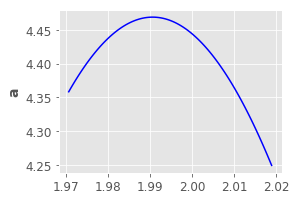

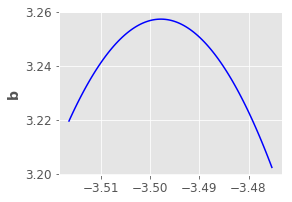

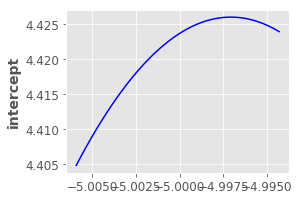

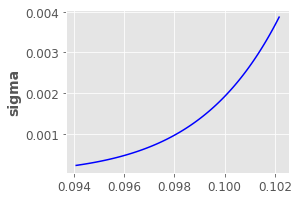

In [82]:
#@title Plot hist
import seaborn as sns

rcParams['figure.figsize'] = 4,3

logsigma = torch.from_numpy(ms.astype(np.float32))
sigma = torch.exp(logsigma.data)

tau =  torch.from_numpy(mm.astype(np.float32))
for id in range(4):

    xx = torch.linspace(float(min(mytheta[:, id].numpy())), float(max(mytheta[:, id].numpy())), 100)
    if id == 3:
        xx = torch.linspace(math.log(float(min(mytheta[:, id].numpy()))), math.log(float(max(mytheta[:, id].numpy()))), 100)
        
    yy =  torch.exp( - 0.5 * torch.pow ( (xx - tau.cpu()[id,0])\
           / sigma.cpu()[id,0], 2)) / math.sqrt( 2. * math.pi ) \
    / sigma.cpu()[id,0]

    
    if id == 3:
        xx = torch.exp(xx)
        yy = yy / xx
        
    #_ = sns.distplot(mytheta[:, id].numpy(), hist=False)

        
    _ = plt.plot(xx.cpu().data.numpy(), yy.cpu().data.numpy(), "b-")

    plt.ylabel(name[id])
    plt.show()


In [117]:
#@title
tf.reset_default_graph()


et = 1e-6
gg = 10.0
deltaUtility = 2 * taubound

privacyBudget = 1.0
def privacyController(utility):
    return privacyBudget * utility / (2*deltaUtility)
     

with tf.device('/cpu:0'):
    D = tf.constant(data.numpy())
    X = D[:, 0:2]
    Y = D[:, 2:3]
    
    vi_mean  = tf.Variable( mm )
    vi_logsigma = tf.Variable( ms )
    vi_sigma = tf.exp(vi_logsigma)

    vi_mean_var  = tf.Variable( tf.zeros([4,1]) )
    vi_logsigma_var = tf.Variable( tf.zeros([4,1]))

    noi = tf.random_normal( [4, 1])
    sample = noi * vi_sigma + vi_mean
    log_posterior = log_pos(X, Y, sample)    

    vi_loss = -(log_posterior + gg * tf.reduce_sum(vi_logsigma)) 
    vi_loss = privacyController(vi_loss)
    
    vi_mean_grad, vi_logsigma_grad = tf.gradients(vi_loss, [vi_mean, vi_logsigma] )
    vi_mean_noise = tf.random_normal( [4, 1]) * math.sqrt(2*et)
    vi_logsigma_noise = tf.random_normal( [4, 1]) * math.sqrt(2*et)
    
    vi_mean_ops = tf.assign_sub(vi_mean, vi_mean_grad * et + vi_mean_noise )
    vi_logsigma_ops = tf.assign_sub(vi_logsigma, vi_logsigma_grad * et + vi_logsigma_noise )
    
    vi_mean_var_ops = tf.assign_add(vi_mean_var,  tf.pow(vi_mean_grad, 2) )
    vi_logsigma_var_ops = tf.assign_add(vi_logsigma_var,  tf.pow(vi_logsigma_grad, 2) )

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
NN = 500000
for i in tqdm.tqdm(range(NN//4)):
    _,_,ll,_,_ = sess.run( (vi_mean_var_ops, vi_logsigma_var_ops, vi_loss, vi_mean_ops, vi_logsigma_ops) )
    #if i % 1000 == 0:
    #    print(ll)

mmm, mms =  sess.run( (vi_mean_var, vi_logsigma_var) )
mv = np.sqrt(mmm / (NN//4))
mls = np.sqrt(mms / (NN//4))
print(mv)
print(mls)


100%|██████████| 125000/125000 [01:11<00:00, 1760.40it/s]

[[101.93008176]
 [117.83236038]
 [474.97880158]
 [ 61.1510518 ]]
[[10.23276229]
 [15.7553059 ]
 [31.95735458]
 [11.47932333]]


In [126]:
#@title
tf.reset_default_graph()


et = 1e-2


with tf.device('/cpu:0'):
    D = tf.constant(data.numpy())
    X = D[:, 0:2]
    Y = D[:, 2:3]
    tfmv = tf.constant(mv, dtype=tf.float32)
    tflsv = tf.constant(mls, dtype=tf.float32)
    
    vi_mean  = tf.Variable( mm )
    vi_logsigma = tf.Variable( ms )
    vi_sigma = tf.exp(vi_logsigma)

    noi = tf.random_normal( [4, 1])
    sample = noi * vi_sigma + vi_mean
    log_posterior = log_pos(X, Y, sample)    

    vi_loss = -(log_posterior + gg * tf.reduce_sum(vi_logsigma)) 
    vi_loss = privacyController(vi_loss)
    
    vi_mean_grad, vi_logsigma_grad = tf.gradients(vi_loss, [vi_mean, vi_logsigma] )
    vi_mean_noise = tf.random_normal( [4, 1]) * tf.sqrt(2*et / tfmv)
    vi_logsigma_noise = tf.random_normal( [4, 1]) * tf.sqrt(2*et / tflsv)
    
    vi_mean_ops = tf.assign_sub(vi_mean, vi_mean_grad * et / tfmv + vi_mean_noise )
    vi_logsigma_ops = tf.assign_sub(vi_logsigma, vi_logsigma_grad * et / tflsv + vi_logsigma_noise )
    

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

NN = 1000000

LLS = []
for i in tqdm.tqdm(range(NN)):
    ll,_,_, vivimean, vivilogsigma = \
    sess.run( (vi_loss, vi_mean_ops, vi_logsigma_ops, vi_mean, vi_logsigma) )
    LLS.append(  (vivimean, vivilogsigma) )
    #if i % 1000 == 0:
    #    print(ll)


100%|██████████| 1000000/1000000 [09:34<00:00, 1740.07it/s]


/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/xcode/anaconda3/lib/python3.6

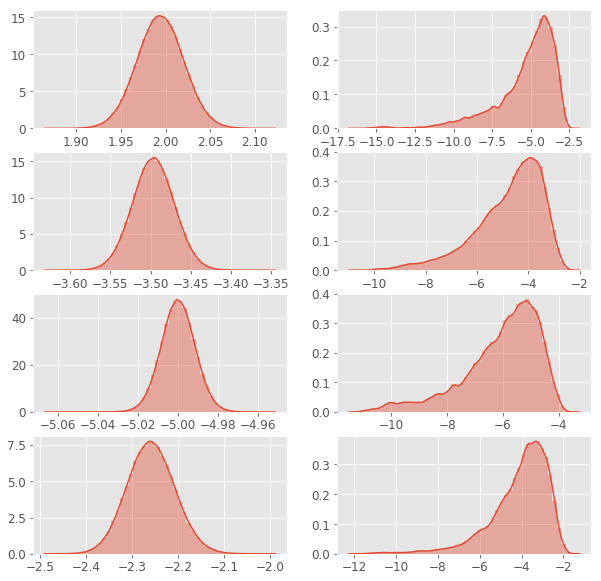

In [127]:
#@title
rcParams['figure.figsize'] = 10,10

for id in range(4):
    for yy in range(2):
        plt.subplot(4,2,id*2 + yy+1)
        ss = [ sample[yy][id] for sample in LLS if not math.isnan(sample[yy][id])]
        sns.distplot(ss)